### Importação das bibliotecas

In [29]:
# Bibliotecas básicas

import numpy as np
import matplotlib.pyplot as plt

# Módulos do snappy

from snappy import ProductIO # Módulo para leitura e escrita de arquivos (produtos)
from snappy import HashMap # Java Hashmap, objeto equivalente a um dicionário do Python
from snappy import GPF # Graph Processing Framework, utilizado para "chamar" os operadores
from snappy import jpy # biblioteca que faz a ponte entre o Python e a API em Java
from snappy import WKTReader # biblioteca para fazera leitura e conversãod e shapefiles para WKT (Well Known Text)

print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


### Função para plotagem da imagem:

In [3]:
def plotBand(data, banda, vmin, vmax):
    
    """
    Argumentos:
    
    data = produto (geralmente uma variável contendo o resultado de algum processamento);
    banda = banda utilizada (Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV).
    
    """
    
    width = data.getSceneRasterWidth() # largura da imagem em pixels
    height = data.getSceneRasterHeight() # Altura da imagem em pixels
    band = data.getBand(banda) # banda selecionada

    band_data = np.zeros(width * height, np.float32) # matriz de zeros a ser populada com os valores dos pixels
    band.readPixels(0, 0, width, height, band_data) # leitura dos pixels da imagem e registo na matriz de zeros

    band_data.shape = height, width # formatação dos dados da imagem

    plt.figure(figsize=(15, 15)) # Tamanho do gráfico
    
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax) # Plotagem da imagem com o matplotlib

    return imgplot

In [4]:
def Op_help(op):
    
        op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(op)
        print('Operator name: {}'.format(op_spi.getOperatorDescriptor().getName()))
        print('Operator alias: {}\n'.format(op_spi.getOperatorDescriptor().getAlias()))
        print('PARAMETERS:\n')

        param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
        
        for param in param_Desc:
            print('{}: {}\nDefault Value: {}'.format(param.getName(), param.getDescription(), param.getDefaultValue()))
            
            value_set = param.getValueSet()
            print(f'Possible other values: {list(value_set)}\n')

In [7]:
Op_help('Polarimetric-Speckle-Filter')

Operator name: org.csa.rstb.polarimetric.gpf.PolarimetricSpeckleFilterOp
Operator alias: Polarimetric-Speckle-Filter

PARAMETERS:

filter: None
Default Value: Refined Lee Filter
Possible other values: ['Box Car Filter', 'IDAN Filter', 'Refined Lee Filter', 'Improved Lee Sigma Filter']

filterSize: The filter size
Default Value: 5
Possible other values: []

numLooksStr: None
Default Value: 1
Possible other values: ['1', '2', '3', '4']

windowSize: None
Default Value: 7x7
Possible other values: ['5x5', '7x7', '9x9', '11x11', '13x13', '15x15', '17x17']

targetWindowSizeStr: None
Default Value: 3x3
Possible other values: ['3x3', '5x5']

anSize: The Adaptive Neighbourhood size
Default Value: 50
Possible other values: []

sigmaStr: None
Default Value: 0.9
Possible other values: ['0.5', '0.6', '0.7', '0.8', '0.9']

searchWindowSizeStr: The search window size
Default Value: 15
Possible other values: ['3', '5', '7', '9', '11', '13', '15', '17', '19', '21', '23', '25']

patchSizeStr: The patch s

In [8]:
def get_georegion_wkt(roi_path):

    """
    Gets the wkt of the region of interest. This wkt is used to subset the imagery.

    The roi file must be a GeoJSON file with a geographic coodinate system (ex. EPSG 4326)

    Args:
    roi_path (string) = path to the roi GeoJSON file
    
    Returns:
        roi wkt (string)
    """ 

    gdf = gpd.read_file(roi_path, dtype=object)

    geom = gdf.geometry.buffer(0.0002).unary_union
    bounds = geom.bounds
    bbox = Polygon.from_bounds(*bounds)
    wkt = bbox.wkt

    return wkt

In [14]:
import geopandas as gpd
from shapely.geometry import Polygon

In [18]:
roi_wkt = get_georegion_wkt("E:/GATEC/Projeto_01/Dados/Area_projeto/bbox_faz_cach_4326.GEOJSON")

C:\Users\jales\anaconda3\envs\snappy\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [19]:
roi_wkt

'POLYGON ((-51.33640790587485 -22.54647070814553, -51.33640790587485 -22.48308971286399, -51.27042858769882 -22.48308971286399, -51.27042858769882 -22.54647070814553, -51.33640790587485 -22.54647070814553))'

In [13]:
Op_help('Subset')

Operator name: org.esa.snap.core.gpf.common.SubsetOp
Operator alias: Subset

PARAMETERS:

bandNames: The list of source bands.
Default Value: None
Possible other values: []

region: The subset region in pixel coordinates.
Use the following format: <x>,<y>,<width>,<height>
If not given, the entire scene is used. The 'geoRegion' parameter has precedence over this parameter.
Default Value: None
Possible other values: []

referenceBand: The band used to indicate the pixel coordinates.
Default Value: None
Possible other values: []

geoRegion: The subset region in geographical coordinates using WKT-format,
e.g. POLYGON((<lon1> <lat1>, <lon2> <lat2>, ..., <lon1> <lat1>))
(make sure to quote the option due to spaces in <geometry>).
If not given, the entire scene is used.
Default Value: None
Possible other values: []

subSamplingX: The pixel sub-sampling step in X (horizontal image direction)
Default Value: 1
Possible other values: []

subSamplingY: The pixel sub-sampling step in Y (vertical im

### Leitura do arquivo (imagem)

In [9]:
s1_file = 'S1A_IW_GRDH_1SDV_20210924T084533_20210924T084558_039821_04B5E0_DB94'

product = ProductIO.readProduct('D:/thesis_data/RAW/GRD/%s.zip' % (s1_file))

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
band_names = product.getBandNames()

print(f'Product: {name}')
print(f'Shape: {width} x {height} pixels')
print(f'Bands: {list(band_names)}')

Product: S1A_IW_GRDH_1SDV_20210924T084533_20210924T084558_039821_04B5E0_DB94
Shape: 25960 x 16831 pixels
Bands: ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']


In [10]:
product

org.esa.snap.core.datamodel.Product(objectRef=0x0000024803790658)

### Correção do arquivo de vetores orbitais da imagem

In [ ]:
# Correção do arquivo de vetores orbitais da imagem

parameters = HashMap()

GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)') # Tipo de arquivo de órbita a ser buscado
parameters.put('polyDegree', '3') # Grau do polinômio
parameters.put('continueOnFail', 'false') # Condição de parada caso haja algo errado

S1A_Orb = GPF.createProduct('Apply-Orbit-File', parameters, product) # Geração da imagem corrigida

print('Correção do arquivo de órbita: 100%')

### Recorte da imagem

O recorte da imagem tem por objetivo diminuir o volume de dados a serem processados e, consequentemente, diminuir o tempo de processamento.

In [ ]:
# Fazendo o recorte da imagem

x = 0 # coordenada X do canto superior esquerdo
y = 9900 # coordenada y do canto superior esquerdo
w = product.getSceneRasterWidth() # coordenada x do canto inferior direito
h = product.getSceneRasterHeight() # coordenada y do canto inferior direito

HashMap = jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

# Instanciando os parâmetros
params = HashMap()
params.put('copyMetadata', True) # Fazer cópia dos metadados
params.put('region', "%s,%s,%s,%s" % (x, y, w, h)) # região de recorte

S1A_Orb_Sub = GPF.createProduct('Subset', params, S1A_Orb) # Geração da imagem recortada

print('Recorte da imagem: 100%')

Vamos utilizar a banda Intensity_VH para prosseguir com os processamentos. Essa banda contém a intensidade do sinal medido pelo sensor do Sentinel-1.

In [ ]:
plotBand(S1A_Orb, 'Intensity_VH', 0, 30000)

In [ ]:
band = S1A_Orb_Sub.getBand('Intensity_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Calibração radiométrica

In [ ]:
# Conversão dos números digitais da imagem em coeficientes de retroespalhamento (Sigma0_VH)

parameters = HashMap()

parameters.put('outputSigmaBand', True) # Definição do tipo de conversão
parameters.put('sourceBands', 'Intensity_VH') # Definição da banda para Intensity_VH
parameters.put('selectedPolarisations', 'VH') # Definição da polarização da banda
parameters.put('outputImageScaleInDb', False) # Resultados em escala linear

S1A_Orb_Sub_Cal = GPF.createProduct('Calibration', parameters, S1A_Orb_Sub) # Geração do produto radiometricamente calibrado

print('Calibração radiométrica: 100%')

Após a calibração radiométrica, a única banda disponível passa a ser a 'Sigma0_VH'.

In [ ]:
band = S1A_Orb_Sub_Cal.getBand('Sigma0_VH')
# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Correção Geométrica

In [ ]:
# Range Doppler Terrain Correction

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')
parameters.put('demName', 'SRTM 3Sec')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('mapProjection', 'EPSG:32721')
parameters.put('alignToStandardGrid', 'true')
parameters.put('standardGridOriginX', 0.0)
parameters.put('standardGridOriginY', 0.0)

S1A_Orb_Sub_Cal_Ter = GPF.createProduct('Terrain-Correction', parameters, S1A_Orb_Sub_Cal)

print('Correção Geométrica: 100%')

In [ ]:
listParams('Terrain-Correction')

In [ ]:
band = S1A_Orb_Sub_Cal_Ter.getBand('Sigma0_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Filtragem de ruído speckle

O filtro utilizado será o filtro de Lee, em um kernel de 3x3 pixels.

In [ ]:
# Aplicação do filtro de ruído speckle

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', '3')
parameters.put('filterSizeY', '3')
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')

S1A_Orb_Sub_Cal_Ter_Spk = GPF.createProduct('Speckle-Filter', parameters, S1A_Orb_Sub_Cal_Ter)

print('Filtagem do ruído speckle: 100%')

In [ ]:
band = S1A_Orb_Sub_Cal_Ter_Spk.getBand('Sigma0_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Conversão para escala em decibeis

In [ ]:
# LinearToFromdB

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')

S1A_Orb_Sub_Cal_Ter_Spk_dB = GPF.createProduct('LinearToFromdB', parameters, S1A_Orb_Sub_Cal_Ter_Spk)

print("Conversão para dB: 100%")

In [ ]:
band = S1A_Orb_Sub_Cal_Ter_Spk_dB.getBand('Sigma0_VH_db')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Salvando a imagem

In [ ]:
ProductIO.writeProduct(S1A_Orb_Sub_Cal_Ter_Spk_Sub_dB, 'C:/Users/jales/Desktop/S1/S1A_2', 'ENVI')

print("Imagem salva com sucesso")

### Importando novamente a imagem

In [ ]:
# Leitura da imagem salva anteriormente

imagem = ProductIO.readProduct('C:/Users/jales/Desktop/S1/S1A_processado/Sigma0_VH_db.hdr')

In [ ]:
# Getting the width of the scene
width = imagem.getSceneRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = imagem.getSceneRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = imagem.getName()
print('Nome do arquivo: {}'.format(name))

# Getting the band names in the imagery
band_names = imagem.getBandNames()
print('Bandas disponíveis para processamento: {}'.format(', '.join(band_names)))

### Plotando o histograma do produto final

In [ ]:
# Histograma da imagem processada

band = imagem.getBand('Sigma0_VH_db')

w = imagem.getSceneRasterWidth()
h = imagem.getSceneRasterHeight()

band_data = np.zeros(w * h, np.float32)
band.readPixels(0, 0, w, h, band_data)
band_data.shape = h, w

histogram = plt.hist(band_data, bins=2600, range=[-31, -5])

plt.show()

In [ ]:
def thresholding(counts, bins):
    
    x = dict(zip(counts, bins))
    
    max_global = max(x.keys())
    
    dict_max_local = {k:v for (k,v) in x.items() if -40 < v < -17}
    max_local = max(dict_max_local.keys())
    
    dict1_cond = {k:v for (k,v) in x.items() if x[max_global] > v > x[max_local]}
    
    key_threshold = min(dict1_cond.keys())
    
    return x[key_threshold]

In [ ]:
counts = histogram[0]
bins = histogram[1]

thresholding(counts, bins)

In [ ]:
counts

In [ ]:
bins

In [ ]:
x = dict(zip(counts, bins))

In [ ]:
x

In [ ]:
max_global = max(x.keys())

In [ ]:
max_global

In [ ]:
dict_max_local = {k:v for (k,v) in x.items() if -40 < v < -17}

In [ ]:
max_local = max(dict_max_local.keys())

In [ ]:
max_local

In [ ]:
x[max_local]

In [ ]:
dict1_cond = {k:v for (k,v) in x.items() if x[max_global] > v > -25}

In [ ]:
minimo = min(dict1_cond.keys())

In [ ]:
y[minimo]

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon

In [ ]:
def get_georegion_wkt(roi_path):

    """
    Gets the wkt of the region of interest. This wkt is used to subset the imagery.

    The roi file must be a GeoJSON file with a geographic coodinate system (ex. EPSG 4326)

    Args:
    roi_path (string) = path to the roi GeoJSON file
    
    Returns:
        roi wkt (array)
    """ 

    gdf = gpd.read_file(roi_path, dtype=object)

    geom = gdf.geometry.buffer(0.0002).unary_union
    bounds = geom.bounds
    bbox = Polygon.from_bounds(*bounds)
    wkt = bbox.wkt

    return wkt

In [ ]:
wkt = get_georegion_wkt('E:/GATEC/Projeto_01/Dados/Area_projeto/bbox_faz_cach_4326.GEOJSON')

In [ ]:
wkt

In [1]:
import numpy as np

In [7]:
kernel = np.ones((5,5), np.float32) / (5*5)

In [8]:
kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

In [65]:
window = np.ones((3,3))
matrix = np.ones((100,100))

In [66]:
def conv2d(matrix, window):

    filtered = np.zeros(matrix.shape)
    wspad = int(window.shape[0]/2)
    
    s = window.shape + tuple(np.subtract(matrix.shape, window.shape) + 1)

    # convolution type
    strd = np.lib.stride_tricks.as_strided
    subM = strd(matrix, shape=s, strides = matrix.strides * 2)

    filtered_data = np.einsum('ij,ijkl->kl', window, subM)
    filtered[wspad:wspad + filtered_data.shape[0], wspad:wspad + filtered_data.shape[1]] = filtered_data

    return filtered

In [69]:
test = conv2d(np.imag(matrix), kernel)

In [70]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

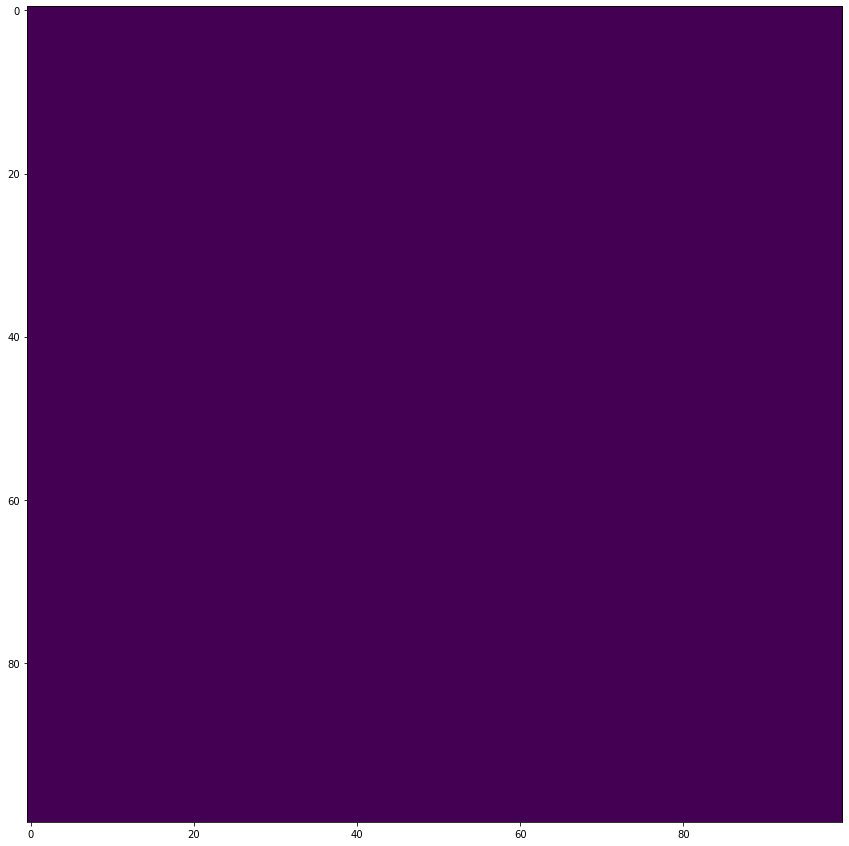

In [71]:
fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(test)

In [72]:
ls = [1/3]*3

In [73]:
prod = 'S1B_IW_SLC__1SDV_20200904T085441_20200904T085508_023223_02C1A1_0F5F.zip'

In [78]:
prod.split('_')[5]

'20200904T085441'

In [79]:
import rasterio as rst

In [83]:
with rst.open('E:/GATEC/Projeto_01/Dados/Imagens/SAR/preprocessadas/S1_split_Orb_Cal_Deb_Sub_Mul_C2_Spk_TC_1SDV_3857.tif') as raster:
    c11 = raster.read(1)
    c12_real = raster.read(2)
    c12_imag = raster.read(3)
    c22 = raster.read(4)

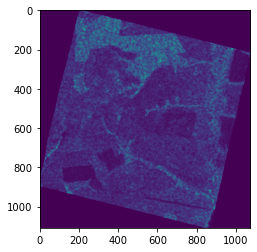

In [87]:
plt.imshow(c22)

In [ ]:
def prvi_index(c11, c12_real, c12_imag, c22, window_size):

    """
    PRVIdp - Polarimetric Radar Vegetation Index (Dual Polarization)

    Args:
    DOP (array) = Degree of polarization
    beta (array) = Dominancy of the scattering mechanism
    
    Returns:
        PRVIdp (array) 
    """

    kernel = np.ones((window_size, window_size), np.float32) / (window_size * window_size)

    c11_T1 = c11
    c12_T1 = c12_real
    c21_T1 = c12_imag
    c22_T1 = c22

    c11_T1r = conv2d(np.real(c11_T1), kernel)
    c11_T1i = conv2d(np.imag(c11_T1), kernel)
    c11s = c11_T1r + 1j * c11_T1i

    c12_T1r = conv2d(np.real(c12_T1), kernel)
    c12_T1i = conv2d(np.imag(c12_T1), kernel)
    c12s = c12_T1r + 1j * c12_T1i
    
    c21_T1r = conv2d(np.real(c21_T1), kernel)
    c21_T1i = conv2d(np.imag(c21_T1), kernel)
    c21s = c21_T1r + 1j * c21_T1i

    c22_T1r = conv2d(np.real(c22_T1), kernel)
    c22_T1i = conv2d(np.imag(c22_T1), kernel)
    c22s = c22_T1r + 1j * c22_T1i
    
    c2_det = (c11s * c22s) - (c12s * c21s)
    c2_trace = c11s + c22s

    dop = (np.sqrt(1.0 - (4.0 * c2_det / np.power(c2_trace, 2))))

    prvi = (1 - dop) * c22s

    return prvi.astype(np.float32)